In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.datasets import load_iris
from ml_tooling import BaseClassModel
from ml_tooling.baseclass import logger
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [23]:
class IrisModel(BaseClassModel):
    def get_training_data(self):
        data = load_iris()
        return pd.DataFrame(data=data.data, columns=data.feature_names), np.where(data.target == 1, 1, 0)
    
    def get_prediction_data(self):
        pass

In [24]:
rf_clf = IrisModel(RandomForestClassifier(n_estimators=10))

In [32]:
rf_clf.config.RANDOM_STATE = 42

In [33]:
rf_clf.config

<Config: 
VERBOSITY: 0
CLASSIFIER_METRIC: accuracy
REGRESSION_METRIC: r2
CROSS_VALIDATION: 10
STYLE_SHEET: /home/anders/Projects/ml_tooling/src/ml_tooling/almbrand.mplstyle
N_JOBS: -1
TEST_SIZE: 0.25
RANDOM_STATE: 42
RUN_DIR: /home/anders/Projects/ml_tooling/notebooks/runs
MODEL_DIR: /home/anders/Projects/ml_tooling/notebooks/models
LOG: False
>

In [27]:
result = rf_clf.score_model(metric='roc_auc', cv=10)

[15:13:47] - Scoring model...
[15:13:47] - Cross-validating...
[15:13:47] - RandomForestClassifier - roc_auc: 1.0


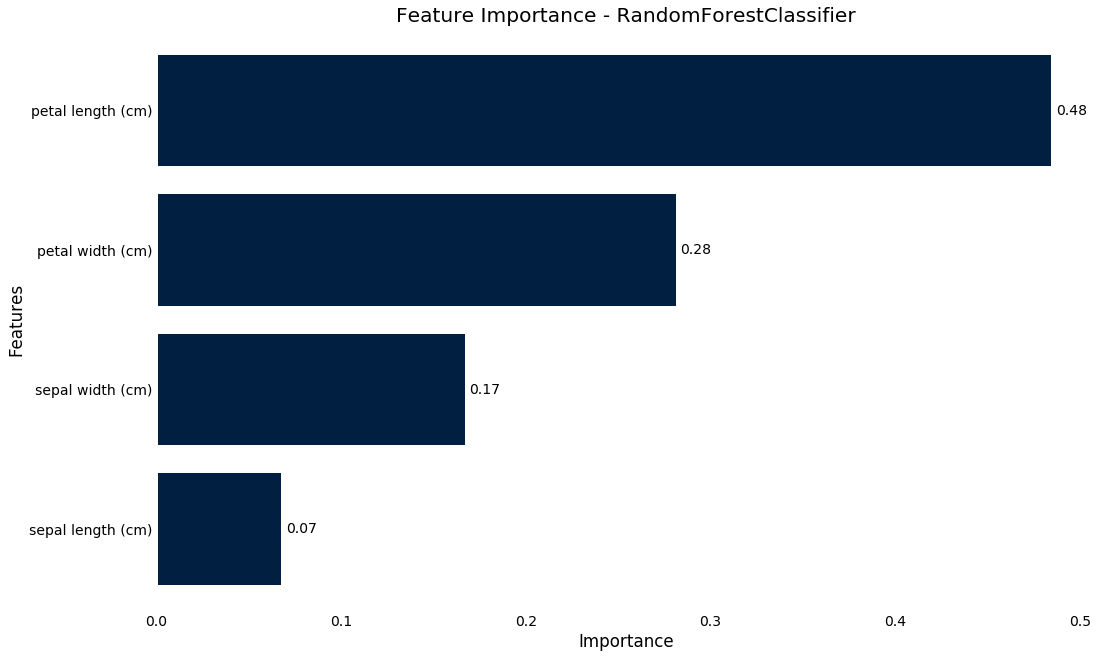

In [26]:
ax = result.plot.feature_importance()

In [41]:
with rf_clf.log('./gridsearch'):
    best_model, results = rf_clf.gridsearch({"max_depth": [5, 10, 15]})

[15:18:55] - Starting gridsearch...
[15:18:57] - Done!
[15:18:57] - Saved run info at None


In [38]:
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
results.to_dataframe()

,bootstrap,class_weight,criterion,max_depth,max_features,max_leaf_nodes,metric,min_impurity_decrease,min_impurity_split,min_samples_leaf,...,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,score,verbose,warm_start,cross_val_std,cv
0,True,None,gini,5,auto,None,accuracy,0.0,None,1,...,0.0,10,None,False,None,0.937222,0,False,0.067406,10
1,True,None,gini,15,auto,None,accuracy,0.0,None,1,...,0.0,10,None,False,None,0.937222,0,False,0.067406,10
2,True,None,gini,10,auto,None,accuracy,0.0,None,1,...,0.0,10,None,False,None,0.928889,0,False,0.064205,10


In [40]:
with rf_clf.log('./test'):
    rf_clf.score_model()

[15:17:34] - Scoring model...
[15:17:34] - RandomForestClassifier - accuracy: 0.8947368421052632
[15:17:34] - Saved run info at /home/anders/Projects/ml_tooling/notebooks/runs/test/20181121/RandomForestClassifier_accuracy_0.895_1517.yaml


In [45]:
with rf_clf.log('./save'):
    rf_clf.save_model()

[15:21:23] - Saved model to /home/anders/Projects/ml_tooling/notebooks/models/IrisModel_RandomForestClassifier_f8021acf332eca0e8e552c63212d30aa5d5333cc.pkl


In [43]:
test_clf = IrisModel.load_model()

[15:20:43] - Loaded RandomForestClassifier for IrisModel


In [44]:
test_clf.model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
from sklearn.dummy import DummyClassifier

In [ ]:
rf_clf

In [ ]:
IrisModel()

In [47]:
best_model, results = IrisModel.test_models([RandomForestClassifier(), DummyClassifier()], log_dir='')

[15:22:43] - Training model 1/2: RandomForestClassifier
[15:22:43] - Scoring model...
/home/anders/miniconda3/envs/ml_tooling/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[15:22:43] - RandomForestClassifier - accuracy: 0.9473684210526315
[15:22:43] - Training model 2/2: DummyClassifier
[15:22:43] - Scoring model...
[15:22:43] - DummyClassifier - accuracy: 0.4473684210526316
[15:22:43] - Best model: RandomForestClassifier - accuracy: 0.9473684210526315


In [49]:
results.to_dataframe()

/home/anders/Projects/ml_tooling/src/ml_tooling/result.py:196: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(output, ignore_index=True).sort_values(by='score', ascending=False)


,bootstrap,class_weight,constant,criterion,max_depth,max_features,max_leaf_nodes,metric,min_impurity_decrease,min_impurity_split,...,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,score,strategy,verbose,warm_start
0,True,None,NaN,gini,None,auto,None,accuracy,0.0,None,...,2.0,0.0,10.0,None,False,None,0.947368,NaN,0.0,False
1,NaN,NaN,None,NaN,NaN,NaN,NaN,accuracy,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,0.447368,stratified,NaN,NaN


In [16]:
results.to_dataframe()

,bootstrap,class_weight,criterion,max_depth,max_features,max_leaf_nodes,metric,min_impurity_decrease,min_impurity_split,min_samples_leaf,...,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,score,verbose,warm_start,cross_val_std,cv
0,True,None,gini,5,auto,None,accuracy,0.0,None,1,...,0.0,10,None,False,None,0.937222,0,False,0.067406,10
1,True,None,gini,15,auto,None,accuracy,0.0,None,1,...,0.0,10,None,False,None,0.937222,0,False,0.067406,10
2,True,None,gini,10,auto,None,accuracy,0.0,None,1,...,0.0,10,None,False,None,0.928889,0,False,0.064205,10
